# import

In [112]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as  plt
import numpy as np

# Dataset

In [1]:
words = open('names.txt', 'r').read().splitlines()

In [2]:
len(words)

32033

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [13]:
b = {}
for word in words:
    word = ['<S>'] + list(word) + ['<E>']
    for c1, c2 in zip(word, word[1:]):
        bigram = (c1, c2)
        b[bigram] = b.get(bigram, 0) + 1

In [17]:
sorted(b.items(), key=lambda x:x[1], reverse=True)[:10]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963)]

In [18]:
import torch

/home/taylor/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
stoi = {chr(97 +i): i+1 for i in range(26)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [42]:
N = torch.zeros((28, 28), dtype=int)
for word in words:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        N[stoi[c1], stoi[c2]] += 1

In [31]:
import matplotlib.pyplot as plt

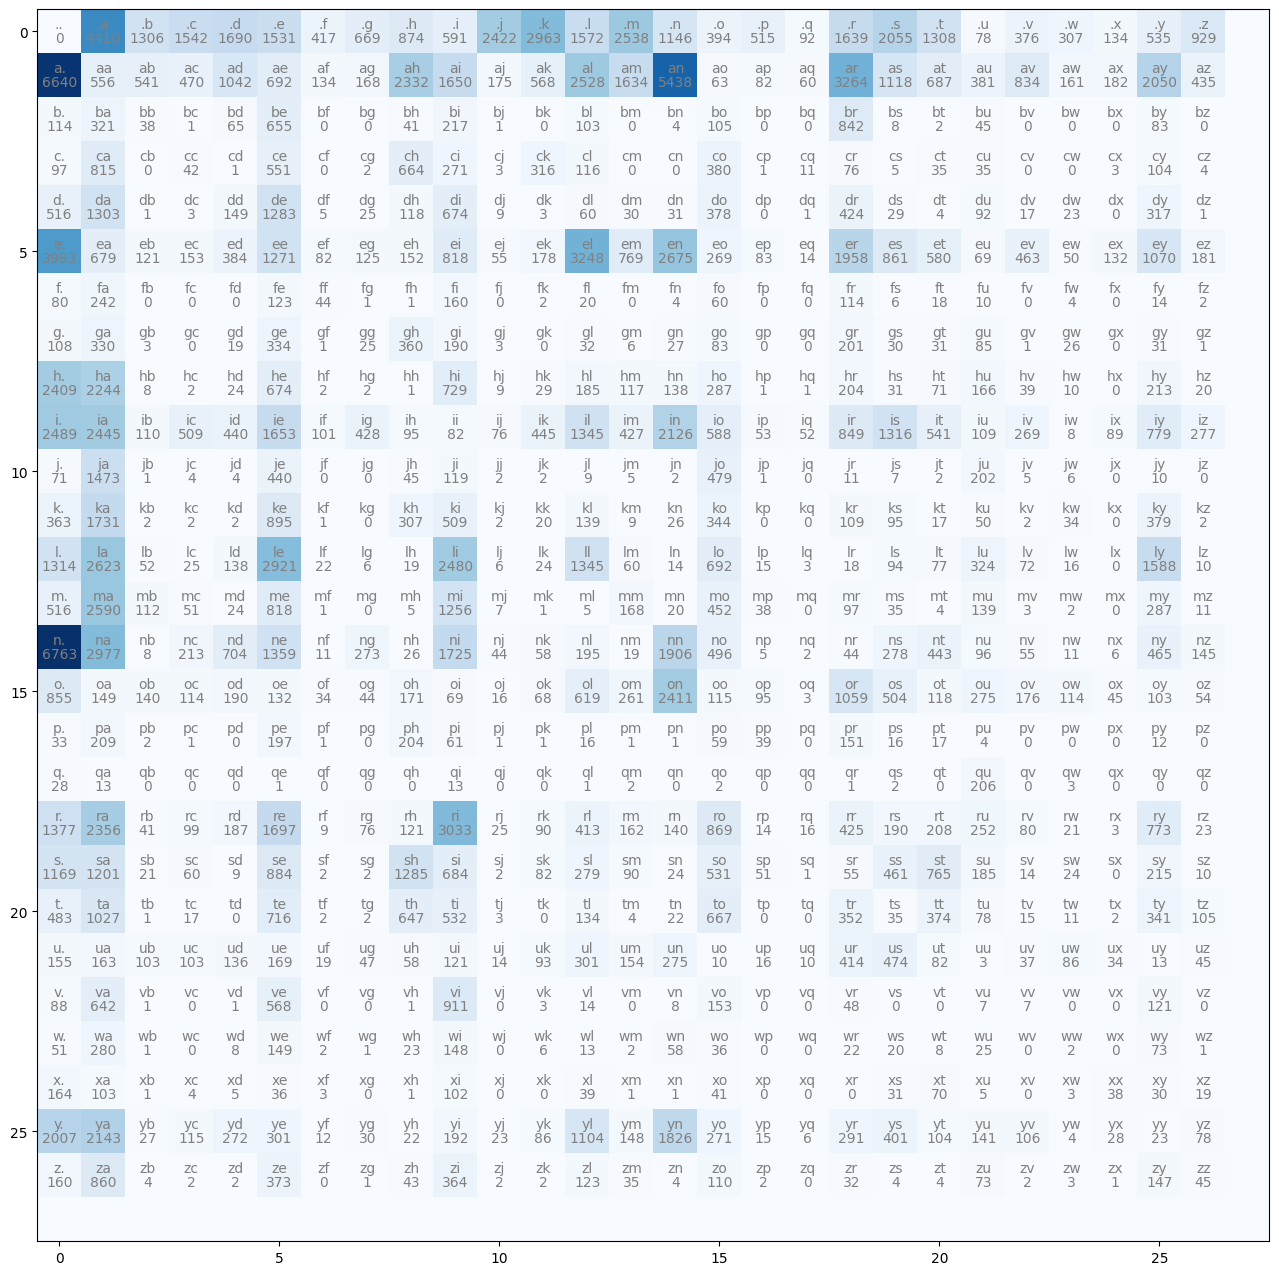

In [44]:
plt.figure(figsize=(16, 16))

plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        plt.text(j, i, itos[i] + itos[j], ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')


In [45]:
first_char = '.'

In [51]:
def generate_next(char):
    p = N[stoi[char], :] 
    p = p /p.sum()
    return itos[torch.multinomial(p, 1).item()]

In [52]:
generate_next('.')

'n'

In [56]:
name = '.'
while len(name) == 1 or name[-1] != '.':
    name += generate_next(name[-1])
name

'.lelahorinngusoheleletleyayah.'

In [60]:
g = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=g)
p = p/p.sum()

In [61]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [66]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while 1:
        p = N[ix].float()
        p /= p.sum()
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


In [92]:
P = N.float()
P /= P.sum(dim=1, keepdim=True)

# bigram model


In [93]:
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while 1:
        # p = N[ix].float()
        # p /= p.sum()
        p = P[ix]
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


In [94]:
# random model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while 1:
        # p = N[ix].float()
        # p /= p.sum()
        p = torch.ones(27) / 27
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

qvsaayxbqrqmyqwuznivanukotdjvdhd.
qnoymtzduqkatdetkpfjdgigvlejfkrsqlwnirghhzwlu.
idcx.
cekmzucjnjoeovjvrggqrjr.
cfbhabkslpokc.
xtxwbpmknuusxdgzfexhwqpldpdnwzvkyxsqjforqqpfxstwkfoufhvwfhmsuyyotvcvvqpfcbydjcouhkajkhqnnpqmmllaordqy.
gszpw.
zlgijinangzzuulsyvqrufuawavsdbnwvlmrypvgrsfgpshgnmwafqmsjdvbhngvoiigxhkwdltrdkwnagzyknqv.
lfstdqigvncdoidetsukgdp.
cfpjsxeqjcsmjwguzes.


In [81]:
x = torch.rand(size=(2, 6))

In [85]:
x.sum(1) + x

RuntimeError: The size of tensor a (2) must match the size of tensor b (6) at non-singleton dimension 1

In [87]:
x.sum(1).shape

torch.Size([2])

# loss: average negative log likelihood

In [103]:
loss = 0
n = 0
for word in words:
# for word in ['annabelle']:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        ix1, ix2 = stoi[c1], stoi[c2]
        prob = P[ix1, ix2]
        loss -= torch.log(prob)
        n+=1
loss /= n

In [104]:
loss

tensor(2.4541)

### model smoothing

to avoid infinite negative log likelihood (when a bigram has probability 0, log prob will be -inf)

In [106]:
loss = 0
n = 0
for word in ['andrejq']:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        ix1, ix2 = stoi[c1], stoi[c2]
        prob = P[ix1, ix2]
        loss -= torch.log(prob)
        n+=1
loss /= n
print(loss)

tensor(inf)


we can smooth the model by adding a count of 1 to N

In [107]:
N = N + 1
P = N.float()
P /= P.sum(dim=1, keepdim=True)

In [108]:
loss = 0
n = 0
for word in ['andrejq']:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        ix1, ix2 = stoi[c1], stoi[c2]
        prob = P[ix1, ix2]
        loss -= torch.log(prob)
        n+=1
loss /= n
print(loss)

tensor(3.4839)


# neural net

In [174]:
# dataset
xs, ys = [], []

for word in words:
    word = ['.'] + list(word) + ['.']
    for c1, c2 in zip(word, word[1:]):
        ix1, ix2 = stoi[c1], stoi[c2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()


In [175]:
# initialize network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [184]:
# training loop
for k in range(100):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs =counts/ counts.sum(1, keepdim=True)
    loss = - probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
    W.grad = None # set gradient to 0
    loss.backward()
    W.data += -50 * W.grad 
    print(loss)

tensor(2.4878, grad_fn=<AddBackward0>)
tensor(2.4877, grad_fn=<AddBackward0>)
tensor(2.4876, grad_fn=<AddBackward0>)
tensor(2.4875, grad_fn=<AddBackward0>)
tensor(2.4874, grad_fn=<AddBackward0>)
tensor(2.4873, grad_fn=<AddBackward0>)
tensor(2.4872, grad_fn=<AddBackward0>)
tensor(2.4871, grad_fn=<AddBackward0>)
tensor(2.4870, grad_fn=<AddBackward0>)
tensor(2.4869, grad_fn=<AddBackward0>)
tensor(2.4868, grad_fn=<AddBackward0>)
tensor(2.4868, grad_fn=<AddBackward0>)
tensor(2.4867, grad_fn=<AddBackward0>)
tensor(2.4866, grad_fn=<AddBackward0>)
tensor(2.4865, grad_fn=<AddBackward0>)
tensor(2.4864, grad_fn=<AddBackward0>)
tensor(2.4863, grad_fn=<AddBackward0>)
tensor(2.4863, grad_fn=<AddBackward0>)
tensor(2.4862, grad_fn=<AddBackward0>)
tensor(2.4861, grad_fn=<AddBackward0>)
tensor(2.4860, grad_fn=<AddBackward0>)
tensor(2.4860, grad_fn=<AddBackward0>)
tensor(2.4859, grad_fn=<AddBackward0>)
tensor(2.4858, grad_fn=<AddBackward0>)
tensor(2.4858, grad_fn=<AddBackward0>)
tensor(2.4857, grad_fn=<A

In [182]:
# generating


tensor(2.6701, grad_fn=<NegBackward0>)

In [187]:

# generation 
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while 1:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts/counts.sum(1, keepdim=True)

        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

mor.
axx.
minaymoryles.
kondmaisah.
anchshizarie.


we get the same model as with the counting, but with an optimization based approach with a single linear layer <br>
NN model: <br>
- one hot encoding of input char
- linear mat mut with W (27 x 27) to get logits for the next char 
- softmax to get proba
- Loss: negative log likelihood 